In [79]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#make pandas display all columns
pd.set_option('display.max_columns', None)

san_diego = pd.read_csv('san_diego_listing_cleaned.csv')
san_diego.head()

,id,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,6,North Park Craftsmen House * Great for Families,29,Sara,2008-03-03,within an hour,100%,100%,f,t,North Hills,32.75522,-117.12873,Entire home,Entire home/apt,6,2.0,2 baths,3.0,3.0,"[""Hair dryer"", ""Children\u2019s bikes"", ""GE ga...",199.0,1,30,1,14,14,275,153,0,0,4.81,4.82,4.71,4.99,4.97,4.77,4.80,0.78
1,12447,Cozy Getaway Pacific Beach Oasis!,48669,Jennifer,2009-10-27,within an hour,100%,90%,t,t,Pacific Beach,32.80533,-117.23400,Private room in condo,Private room,2,1.0,1 private bath,1.0,0.0,"[""Hair dryer"", ""Microwave"", ""Wifi"", ""Carbon mo...",96.0,6,365,5,17,17,162,2,1,1,5.00,4.00,5.00,5.00,5.00,5.00,5.00,0.01
2,29967,"Great home, 10 min walk to Beach",129123,Michael,2010-05-21,within an hour,100%,77%,t,t,Pacific Beach,32.80751,-117.25760,Entire bungalow,Entire home/apt,6,2.0,2 baths,2.0,3.0,"[""Free parking on premises"", ""Hair dryer"", ""Sh...",227.0,4,365,3,22,47,322,107,14,0,4.77,4.74,4.57,4.93,4.93,4.82,4.77,0.63
3,54001,"La Jolla Cottage, 3Blks 2 Ocean; 2bd1bth, Stei...",252692,Marsha,2010-10-04,within a few hours,100%,78%,t,t,La Jolla,32.81301,-117.26856,Entire guesthouse,Entire home/apt,2,1.0,1 bath,2.0,3.0,"[""Ceiling fan"", ""Hair dryer"", ""Portable heater...",191.0,4,30,1,7,20,49,330,21,2,4.93,4.92,4.94,4.97,4.96,4.97,4.88,2.01
4,62949,Pacific Beach Cozy Private Hideaway Free Bikes,21532,Lisa,2009-06-14,within an hour,100%,97%,t,t,Pacific Beach,32.80621,-117.23372,Entire guest suite,Entire home/apt,2,1.0,1 bath,0.0,0.0,"[""Hair dryer"", ""Portable heater"", ""Self check-...",115.0,1,4,6,20,41,41,1082,120,7,4.86,4.91,4.85,4.96,4.95,4.83,4.81,7.51


In [63]:
numeric_df = san_diego.drop(columns=["id", "name", "host_name", "amenities", "host_since", "bathrooms_text"], axis=1)

numeric_df["host_response_rate"] = numeric_df["host_response_rate"].str.replace("%", "").astype(float)
numeric_df["host_acceptance_rate"] = numeric_df["host_acceptance_rate"].str.replace("%", "").astype(float)

dummy_cols = ["host_response_time", "host_is_superhost", "host_identity_verified", "neighbourhood_cleansed", "property_type", "room_type"]
numeric_df = pd.get_dummies(numeric_df, columns=dummy_cols)

#print categorical columns
print(numeric_df.select_dtypes(include=['object']).columns)
for col in numeric_df.select_dtypes(include=['object']).columns:
    print(numeric_df[col].value_counts())


Index([], dtype='object')


In [64]:
#co
#Find correlation matrix
corr_matrix = numeric_df.corr()
print(corr_matrix.shape)

#Find the most correlated features with price
corr_price = corr_matrix["price"].sort_values(ascending=False)
print("10 most positively correlated features with price")
print(corr_price[:10])
print("10 most negatively correlated features with price")
print(corr_price[-10:])

(190, 190)
10 most positively correlated features with price
price                                 1.000000
bathrooms                             0.646012
bedrooms                              0.610507
accommodates                          0.595608
beds                                  0.561226
property_type_Entire home             0.306324
neighbourhood_cleansed_Mission Bay    0.232610
neighbourhood_cleansed_La Jolla       0.213011
room_type_Entire home/apt             0.208830
property_type_Entire villa            0.176031
Name: price, dtype: float64
10 most negatively correlated features with price
minimum_nights                       -0.099234
property_type_Entire guesthouse      -0.103768
number_of_reviews_l30d               -0.111351
number_of_reviews_ltm                -0.127882
property_type_Entire rental unit     -0.133304
number_of_reviews                    -0.141201
reviews_per_month                    -0.148438
property_type_Private room in home   -0.164061
room_type_Priva

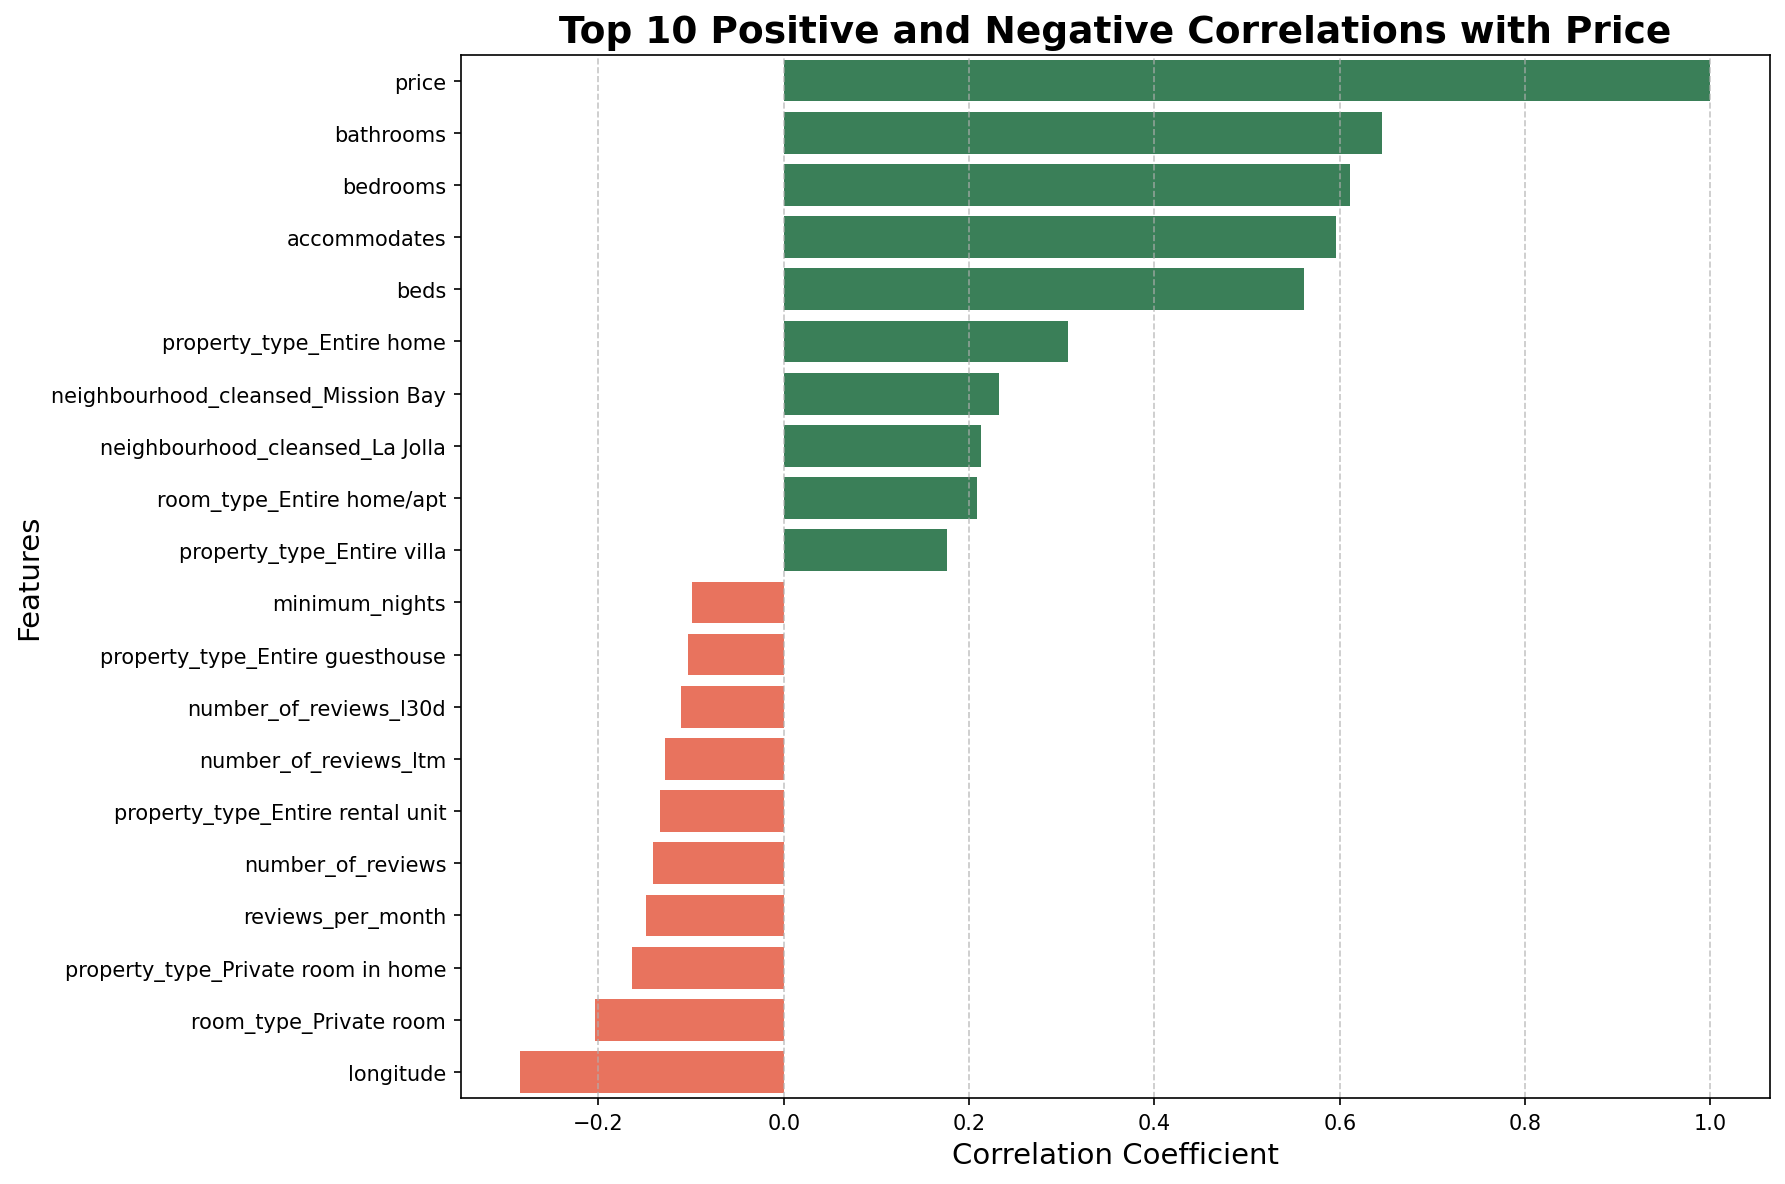

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 10 most positively and negatively correlated features with price
positive_corr = corr_price[:10]
negative_corr = corr_price[-10:]

# Combine both into a single dataframe for visualization
combined_corr = pd.concat([positive_corr, negative_corr])

# Increase figure DPI for better resolution
plt.figure(figsize=(12, 8), dpi=150)

# Create the horizontal bar chart with improved styling
sns.barplot(
    x=combined_corr.values,
    y=combined_corr.index,
    palette=["#2E8B57" if val > 0 else "#FF6347" for val in combined_corr.values]
)

# Add title and labels with larger font sizes
plt.title('Top 10 Positive and Negative Correlations with Price', fontsize=18, weight='bold')
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Enhance grid readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


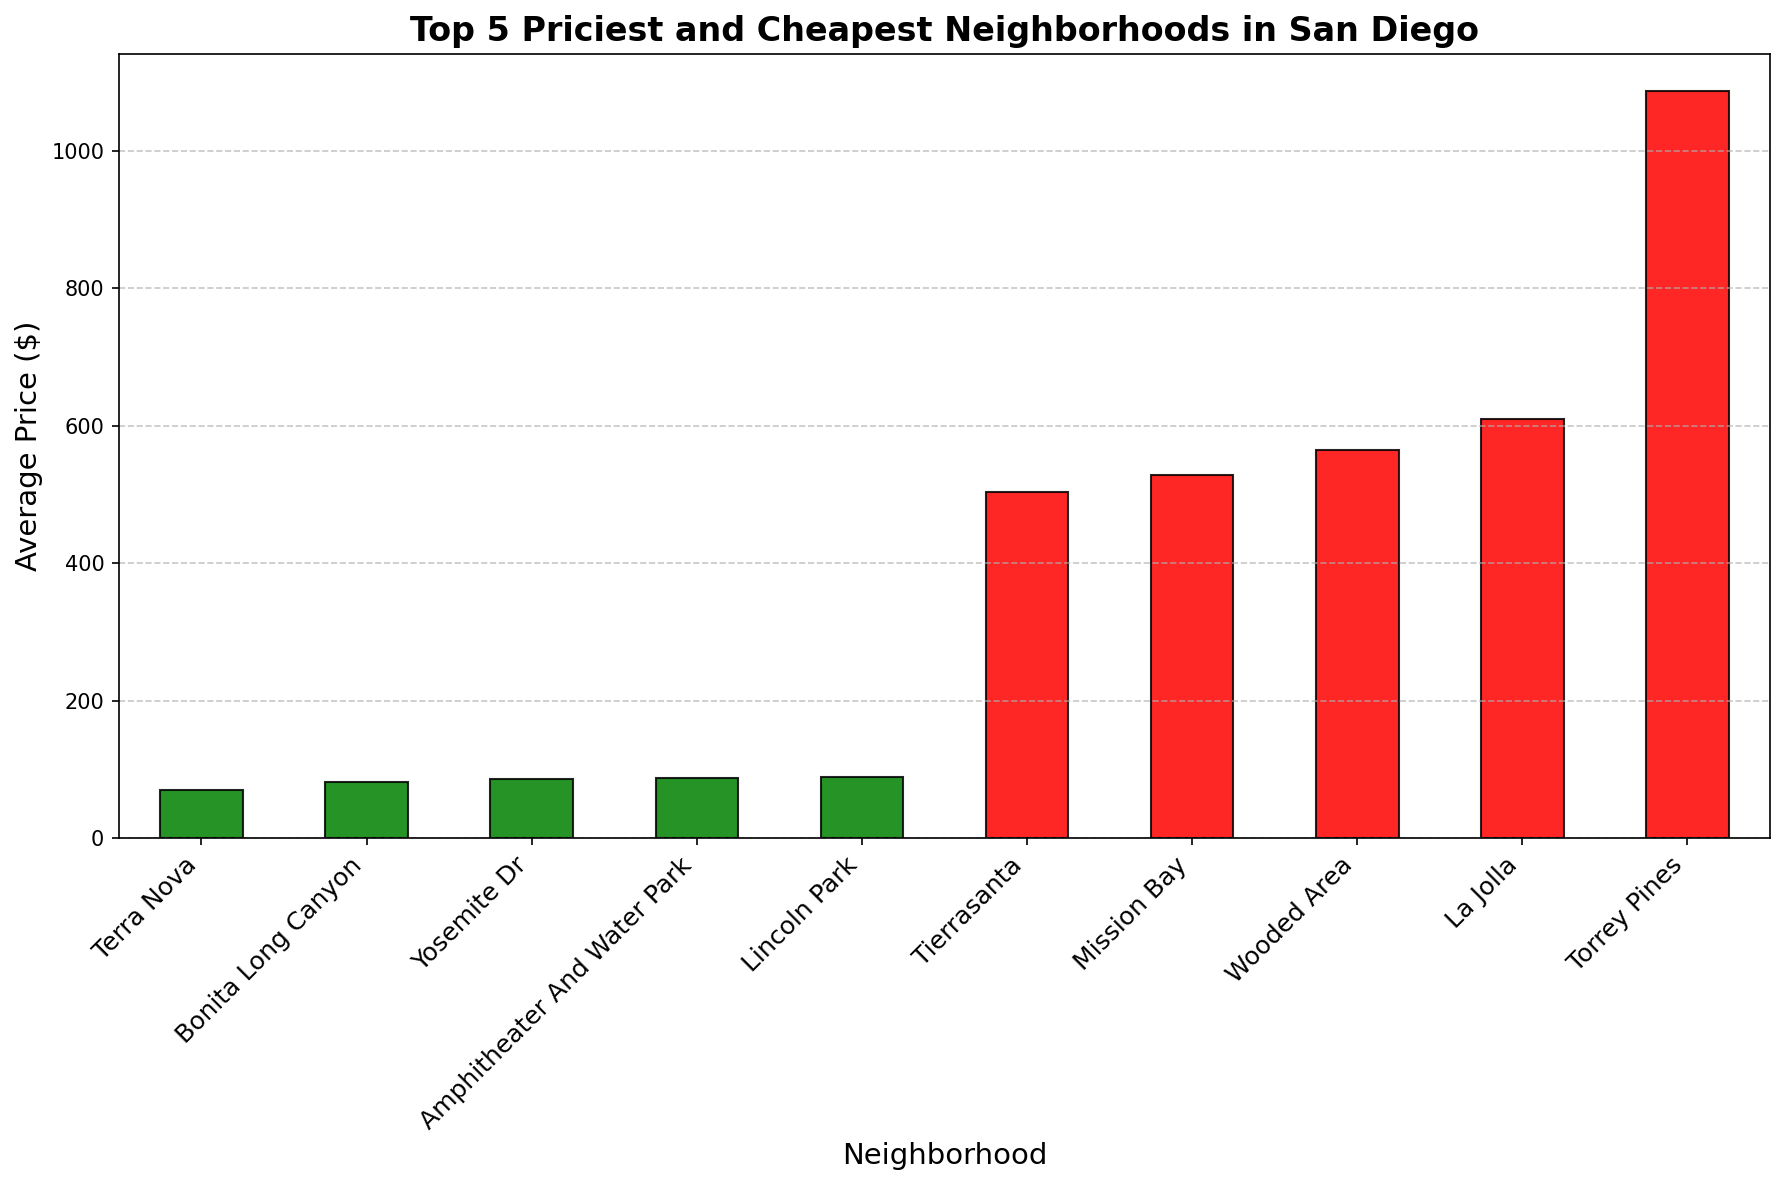

In [66]:
# Group by neighborhood and calculate the average price
avg_price_by_neighborhood = san_diego.groupby("neighbourhood_cleansed")["price"].mean().sort_values()

# Get the cheapest 5 neighborhoods
cheapest_neighborhoods = avg_price_by_neighborhood.head(5)

# Get the top 5 priciest neighborhoods
priciest_neighborhoods = avg_price_by_neighborhood.tail(5)

# Combine the two groups
combined_neighborhoods = pd.concat([cheapest_neighborhoods, priciest_neighborhoods])

# Increase DPI for higher resolution
plt.figure(figsize=(12, 8), dpi=150)

# Plot the data with enhanced styling
combined_neighborhoods.plot(
    kind='bar', 
    color=['green'] * 5 + ['red'] * 5, 
    edgecolor='black',
    alpha=0.85  # Slight transparency for visual appeal
)

# Add title and axis labels with larger fonts
plt.title('Top 5 Priciest and Cheapest Neighborhoods in San Diego', fontsize=16, weight='bold')
plt.ylabel('Average Price ($)', fontsize=14)
plt.xlabel('Neighborhood', fontsize=14)

# Improve x-tick readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add a grid for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure layout fits well
plt.tight_layout()

# Show the plot
plt.show()


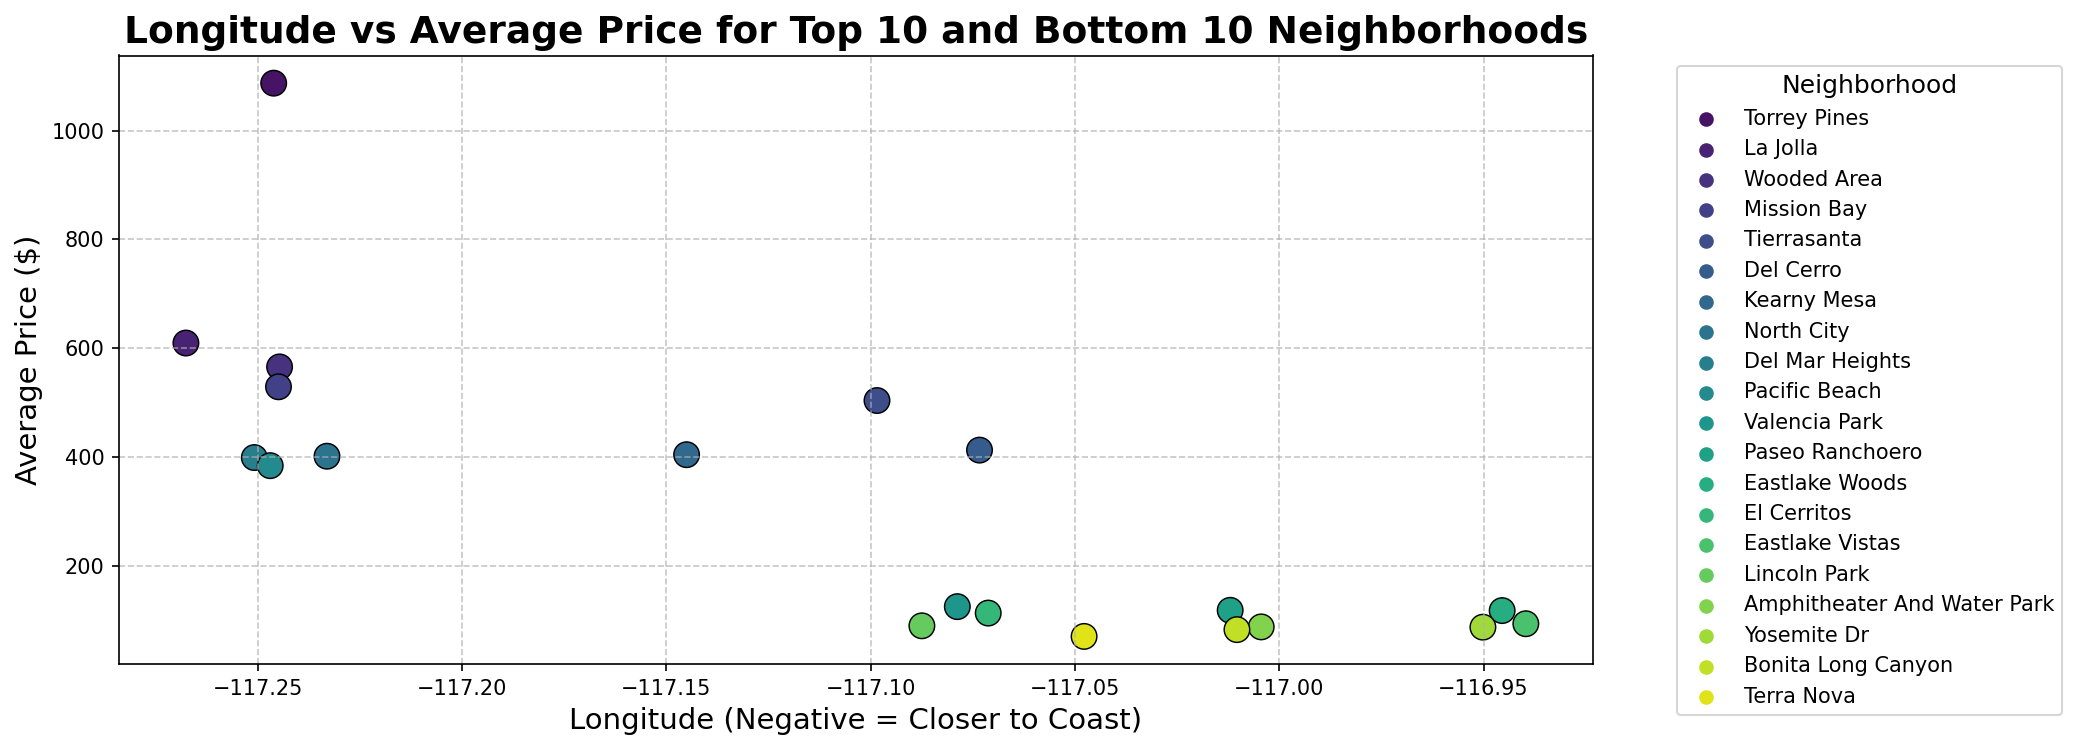

In [67]:
# Group data by neighborhoods and calculate average price and longitude
neighborhood_stats = san_diego.groupby('neighbourhood_cleansed')[['price', 'longitude']].mean().reset_index()

# Sort neighborhoods by average price
sorted_neighborhoods = neighborhood_stats.sort_values(by='price', ascending=False)

# Select top 10 and bottom 10 neighborhoods
top_10_neighborhoods = sorted_neighborhoods.head(10)
bottom_10_neighborhoods = sorted_neighborhoods.tail(10)

# Combine top and bottom neighborhoods for plotting
selected_neighborhoods = pd.concat([top_10_neighborhoods, bottom_10_neighborhoods])

# Set a higher resolution for better image quality
plt.figure(figsize=(14, 5.10), dpi=150)

# Plot a scatterplot of longitude vs. price with enhanced design
sns.scatterplot(
    data=selected_neighborhoods,
    x='longitude',
    y='price',
    hue='neighbourhood_cleansed',
    palette='viridis',
    s=150,  # Increase marker size
    edgecolor='black',  # Add edge color for better contrast
    linewidth=0.7
)

# Add labels and title with larger fonts
plt.title('Longitude vs Average Price for Top 10 and Bottom 10 Neighborhoods', fontsize=18, weight='bold')
plt.xlabel('Longitude (Negative = Closer to Coast)', fontsize=14)
plt.ylabel('Average Price ($)', fontsize=14)

# Customize the legend for better readability
plt.legend(
    title='Neighborhood', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    fontsize=10, 
    title_fontsize=12, 
    frameon=True
)

# Add grid for better reference
plt.grid(linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Neighborhoods in Each Tier:
tier
Tier 1 (Lowest)     [Amphitheater And Water Park, Bonita Long Cany...
Tier 2              [Balboa Park, Bario Logan, City Heights East, ...
Tier 3              [Allied Gardens, Alta Vista, Bay Ho, Carmel Mo...
Tier 4              [Bay Terrace, Bird Land, Carmel Valley, Columb...
Tier 5 (Highest)    [Bay Park, Del Cerro, Del Mar Heights, Estlake...
Name: neighbourhood_cleansed, dtype: object


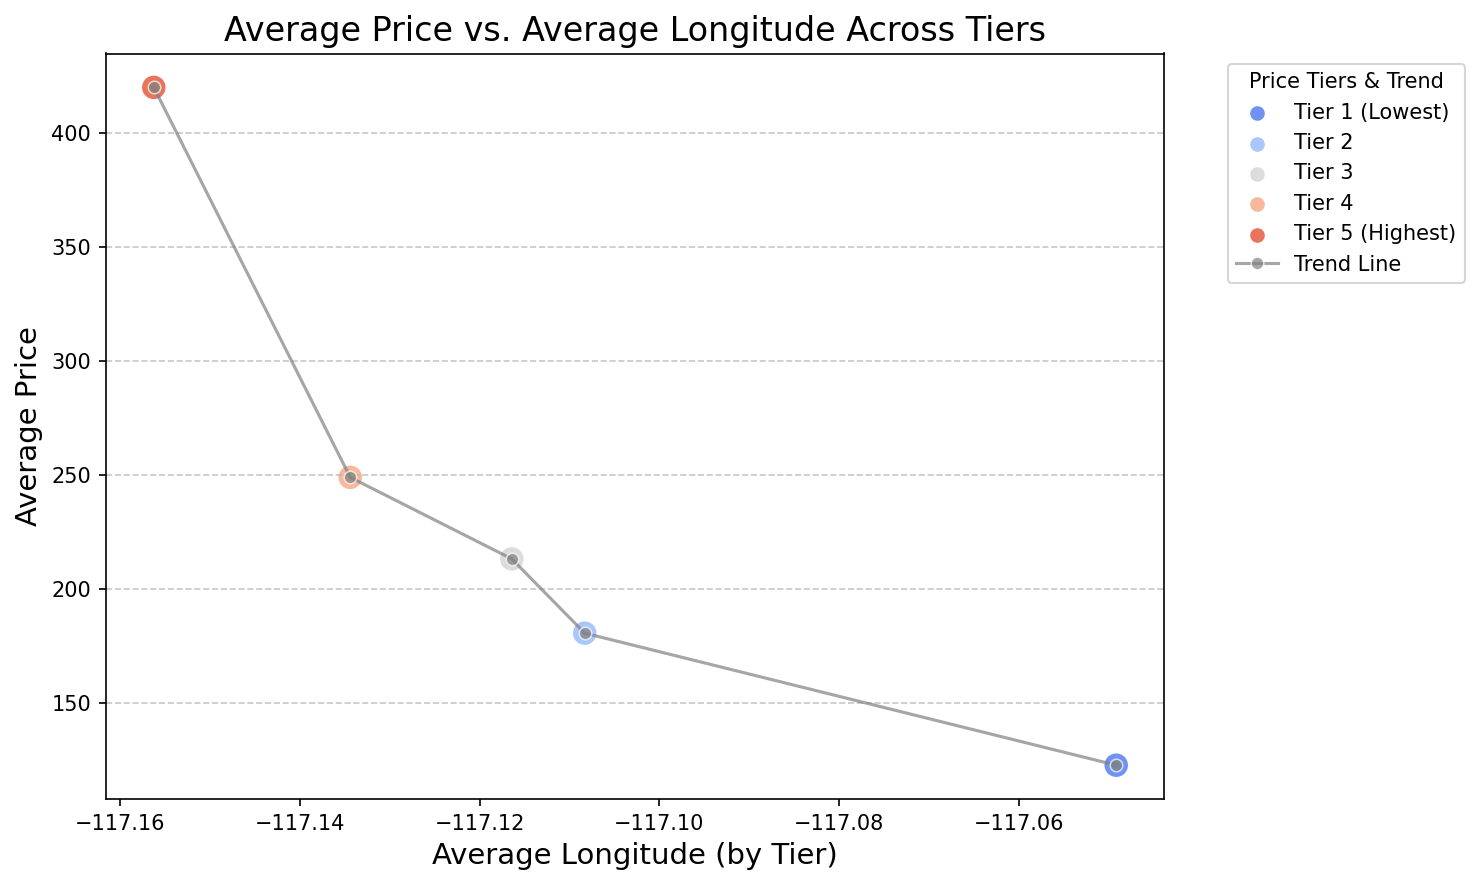

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by neighborhood and calculate average price and longitude
neighborhood_stats = san_diego.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()

# Divide neighborhoods into 5 tiers based on average price
neighborhood_stats['tier'] = pd.qcut(neighborhood_stats['avg_price'], 5, labels=["Tier 1 (Lowest)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Highest)"])

# Calculate average longitude and average price for each tier
tier_stats = neighborhood_stats.groupby('tier').agg(
    avg_price=('avg_price', 'mean'),
    avg_longitude=('avg_longitude', 'mean')
).reset_index()

# Display neighborhoods in each tier
tier_neighborhoods = neighborhood_stats.groupby('tier')['neighbourhood_cleansed'].apply(list)
print("Neighborhoods in Each Tier:")
print(tier_neighborhoods)

# Plot the scatterplot
plt.figure(figsize=(10, 6), dpi=150)
sns.scatterplot(data=tier_stats, x='avg_longitude', y='avg_price', hue='tier', palette='coolwarm', s=150)

# Overlay a line connecting the tiers
sns.lineplot(data=tier_stats, x='avg_longitude', y='avg_price', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

# Add labels and title
plt.title('Average Price vs. Average Longitude Across Tiers', fontsize=16)
plt.xlabel('Average Longitude (by Tier)', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.legend(title='Price Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



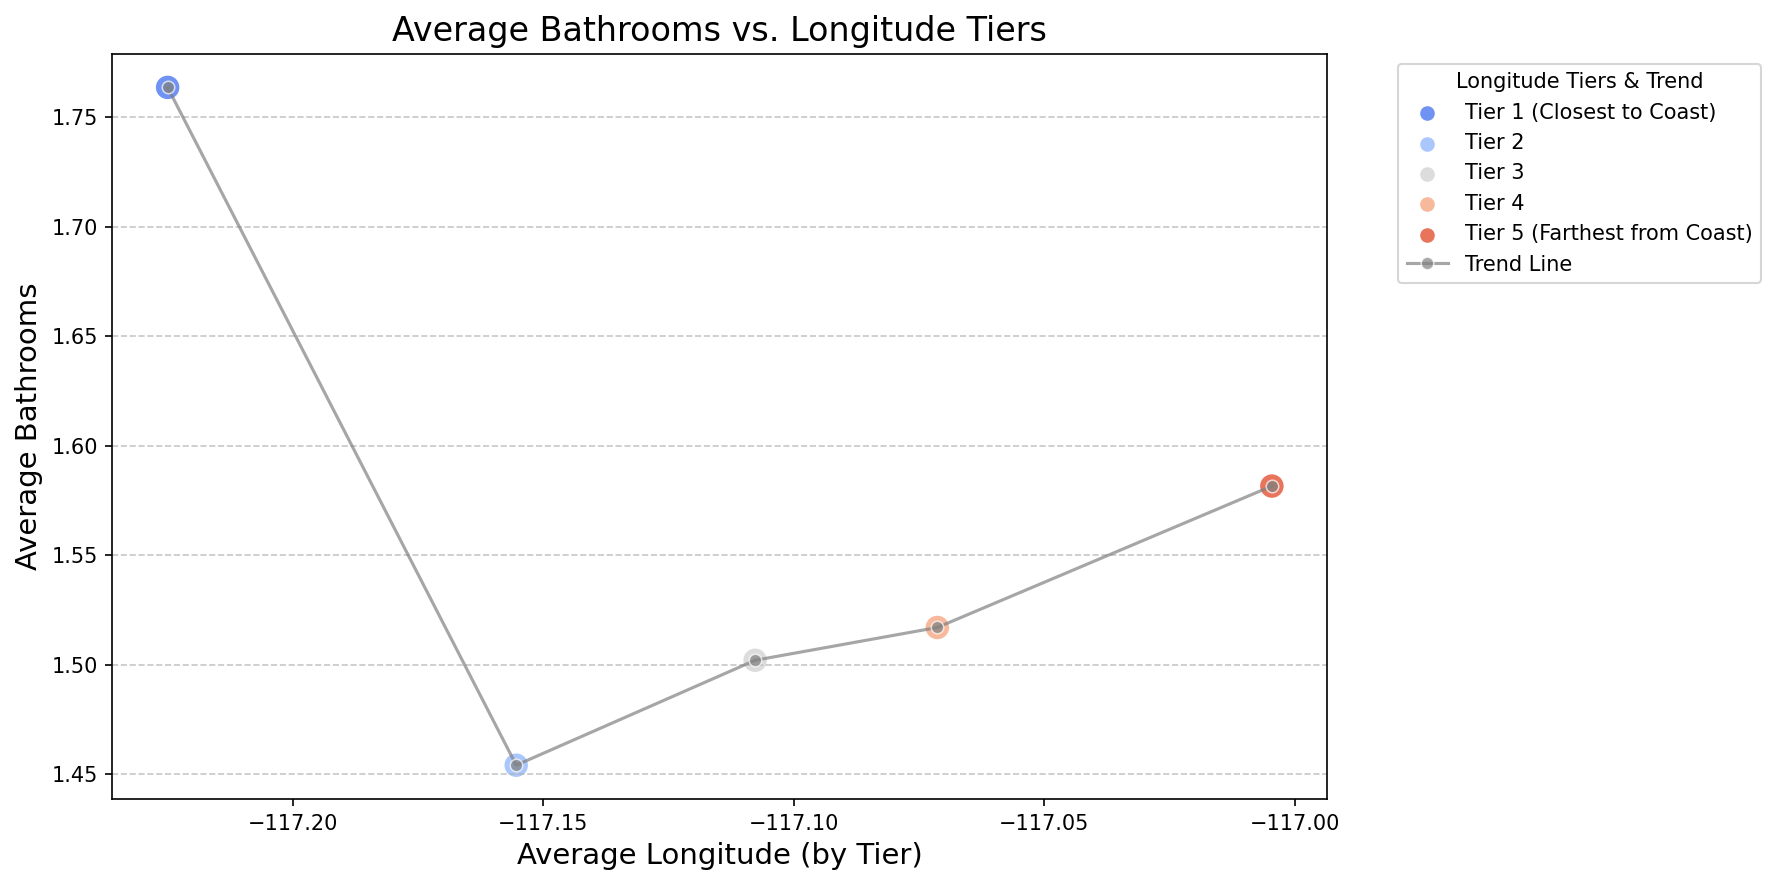

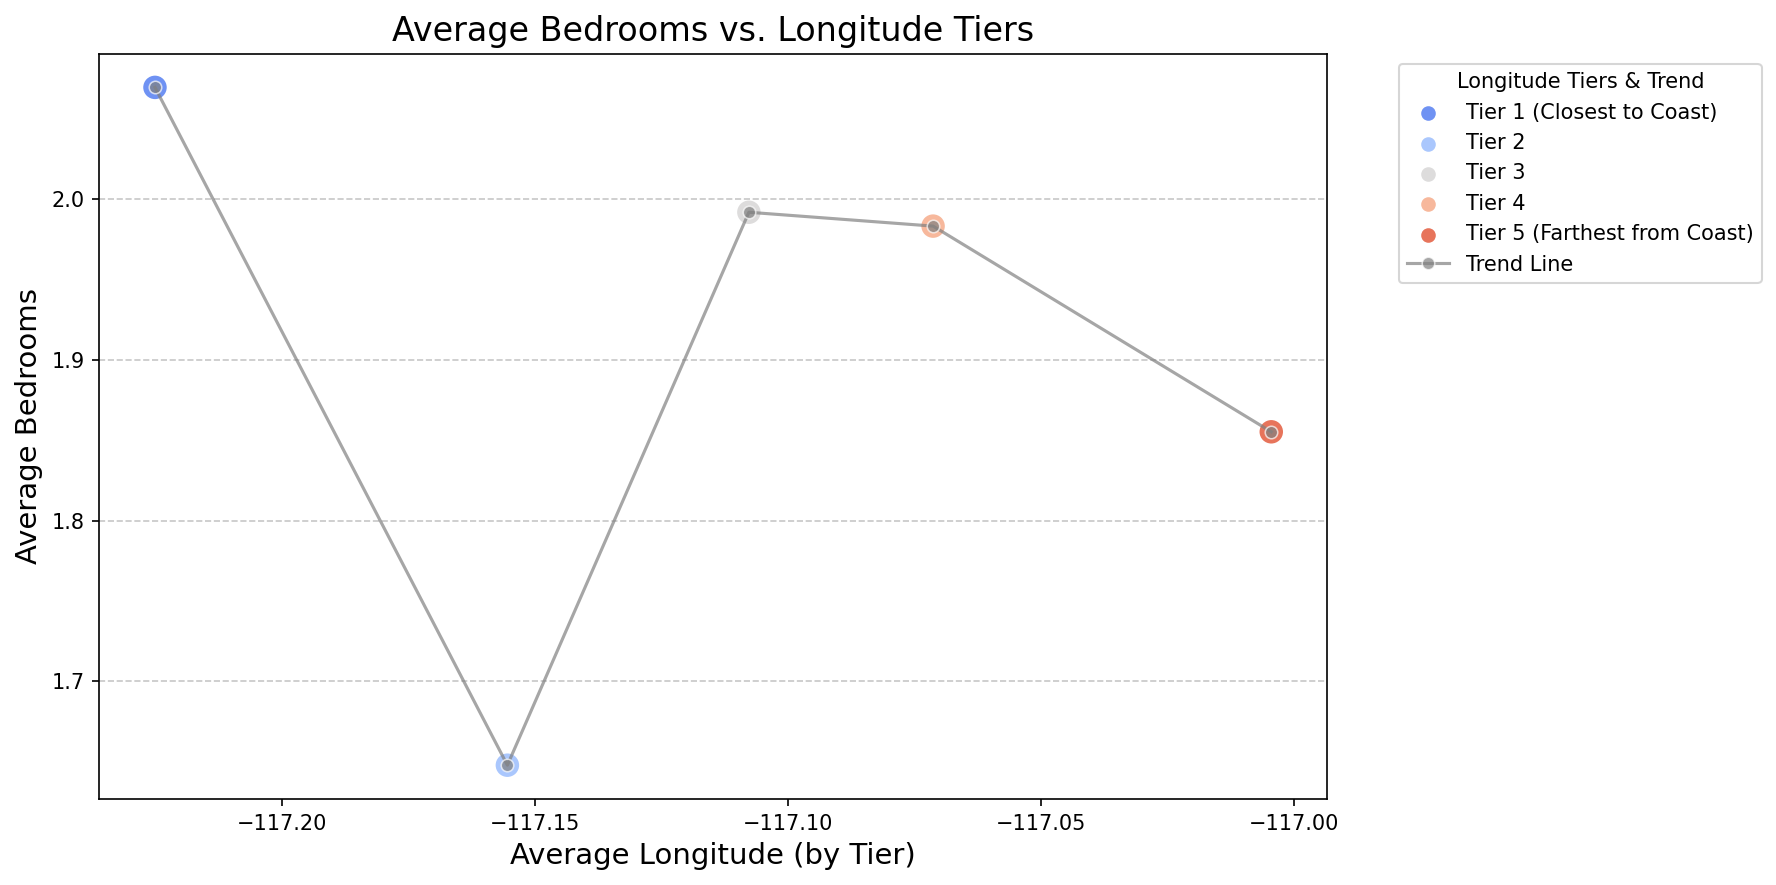

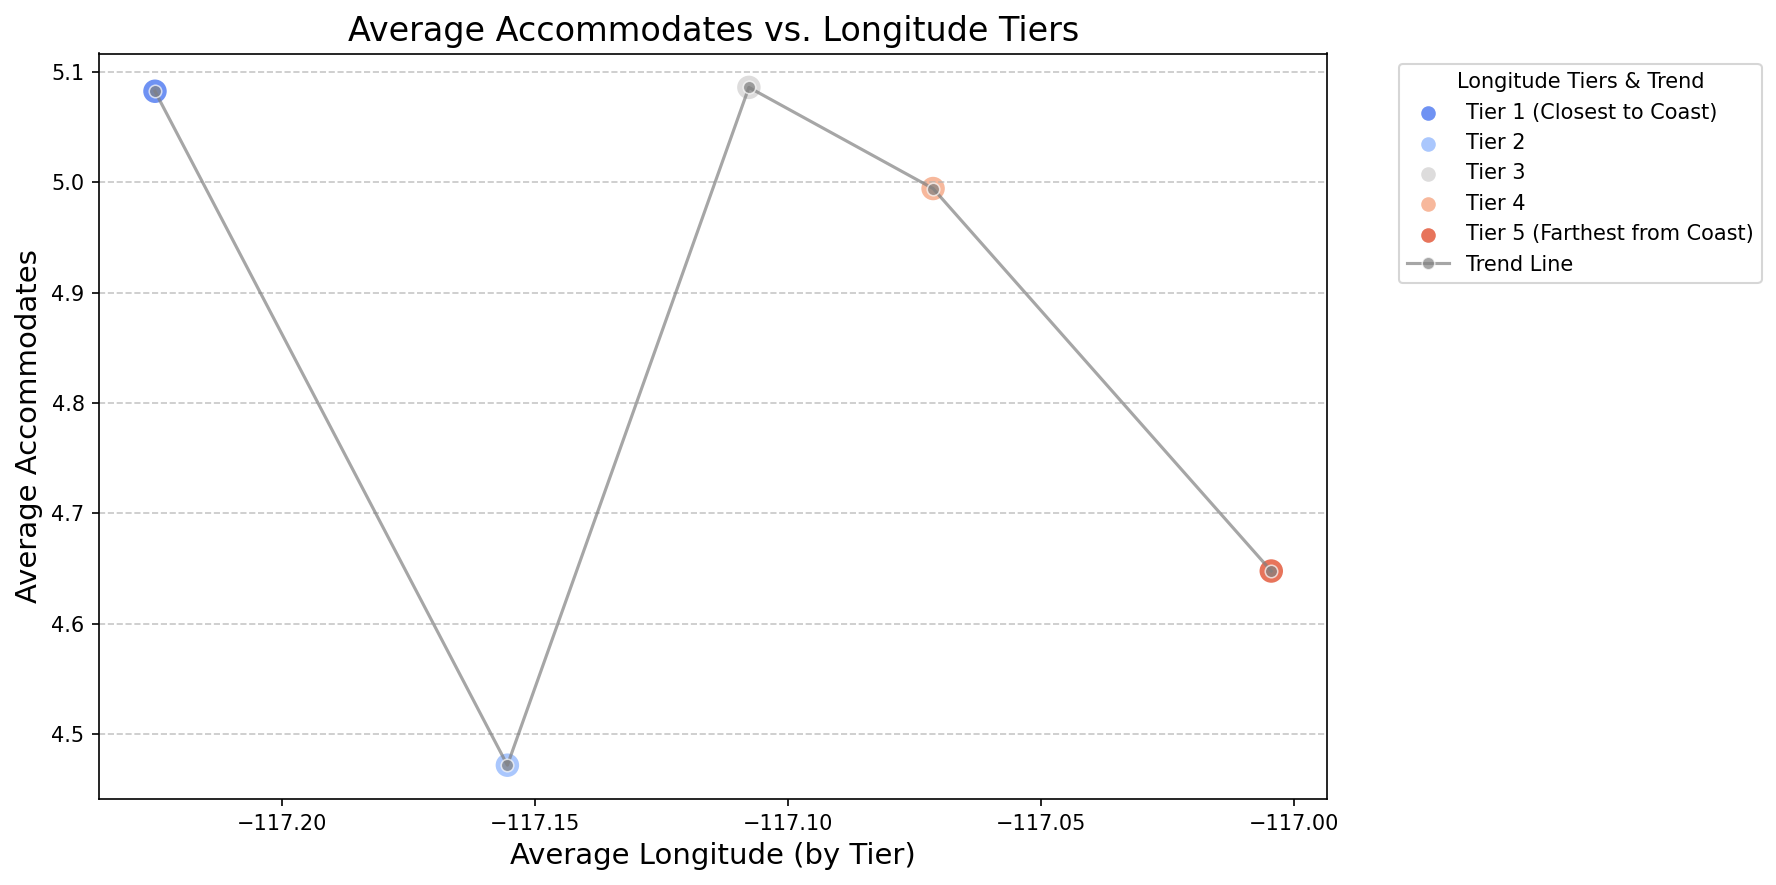

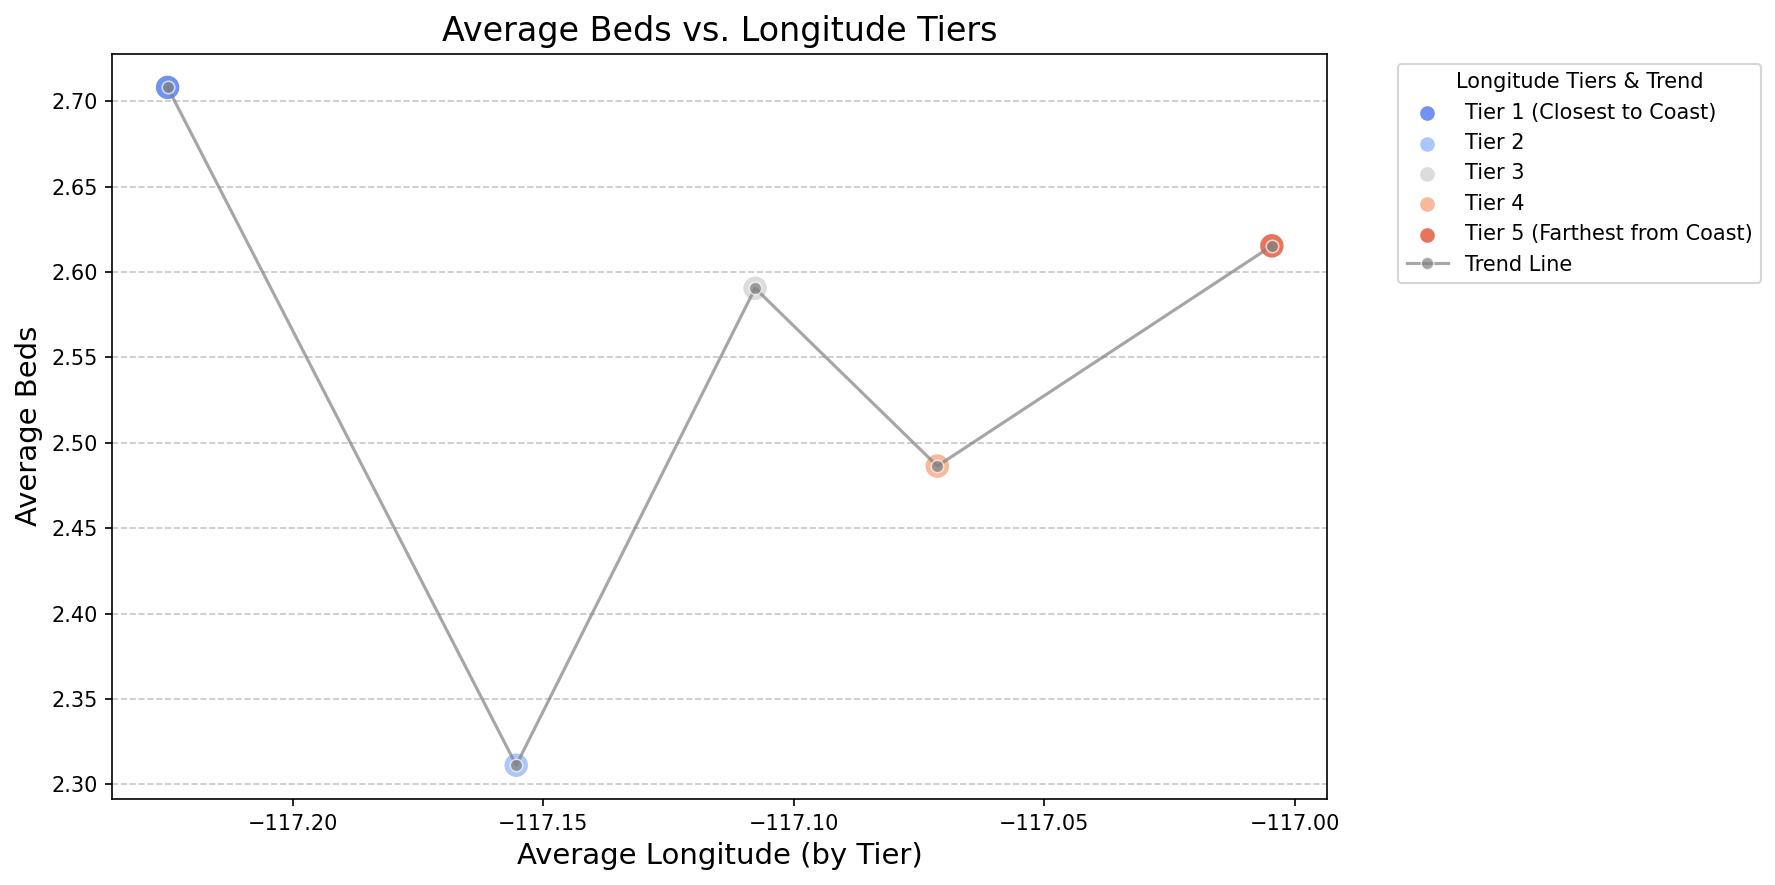

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by neighborhood and calculate average longitude, bathrooms, bedrooms, accommodates, and beds
neighborhood_stats = san_diego.groupby('neighbourhood_cleansed').agg(
    avg_longitude=('longitude', 'mean'),
    avg_bathrooms=('bathrooms', 'mean'),
    avg_bedrooms=('bedrooms', 'mean'),
    avg_accommodates=('accommodates', 'mean'),
    avg_beds=('beds', 'mean')
).reset_index()

# Divide neighborhoods into 5 tiers based on average longitude
neighborhood_stats['tier'] = pd.qcut(neighborhood_stats['avg_longitude'], 5, labels=["Tier 1 (Closest to Coast)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Farthest from Coast)"])

# Define a function to plot the relationship for each feature
def plot_relationship_with_longitude_tiers(df, feature, feature_label):
    # Calculate average feature and longitude for each tier
    tier_stats = df.groupby('tier').agg(
        avg_longitude=('avg_longitude', 'mean'),
        avg_feature=(feature, 'mean')
    ).reset_index()

    # Plot the scatterplot
    plt.figure(figsize=(12, 6), dpi=150)
    sns.scatterplot(data=tier_stats, x='avg_longitude', y='avg_feature', hue='tier', palette='coolwarm', s=150)

    # Overlay a line connecting the tiers
    sns.lineplot(data=tier_stats, x='avg_longitude', y='avg_feature', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

    # Add labels and title
    plt.title(f'Average {feature_label} vs. Longitude Tiers', fontsize=16)
    plt.xlabel('Average Longitude (by Tier)', fontsize=14)
    plt.ylabel(f'Average {feature_label}', fontsize=14)
    plt.legend(title='Longitude Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create plots for bathrooms, bedrooms, accommodates, and beds
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_bathrooms', 'Bathrooms')
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_bedrooms', 'Bedrooms')
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_accommodates', 'Accommodates')
plot_relationship_with_longitude_tiers(neighborhood_stats, 'avg_beds', 'Beds')


Average Prices for Each Longitude-Based Tier:
                           tier   avg_price
0     Tier 1 (Closest to Coast)  360.998403
1                        Tier 2  226.974006
2                        Tier 3  217.491101
3                        Tier 4  198.685281
4  Tier 5 (Farthest from Coast)  181.827885


/tmp/ipykernel_121/111062158.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_avg_price = tier_price_stats.groupby('tier').agg(


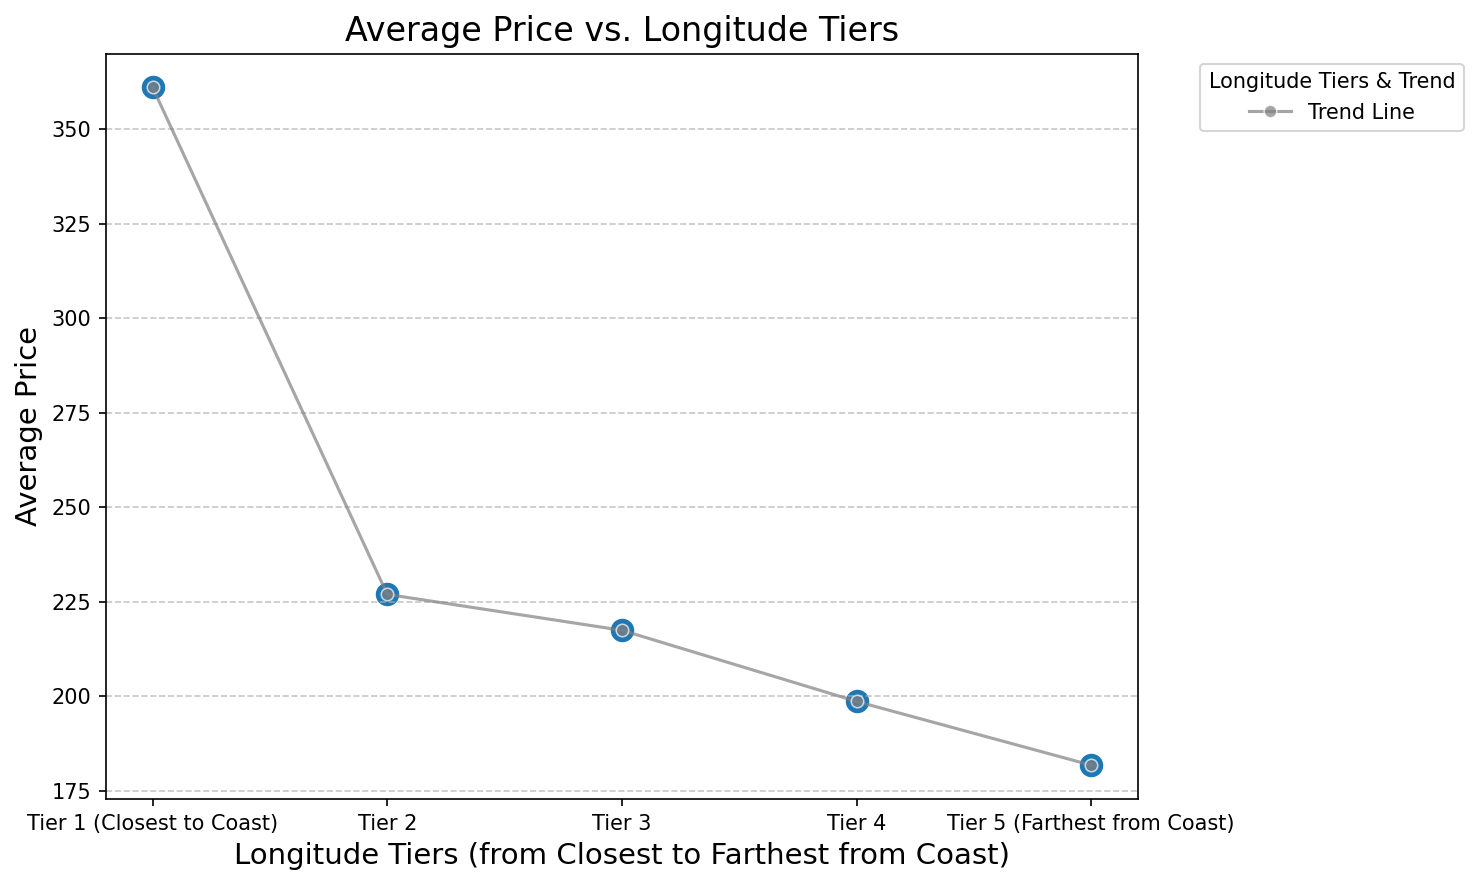

In [139]:
# Calculate average price for each longitude-based tier
tier_price_stats = san_diego.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()

# Divide neighborhoods into 5 tiers based on average longitude (closer to the coast to farther)
tier_price_stats['tier'] = pd.qcut(tier_price_stats['avg_longitude'], 5, labels=["Tier 1 (Closest to Coast)", "Tier 2", "Tier 3", "Tier 4", "Tier 5 (Farthest from Coast)"])

# Calculate the average price for each tier
tier_avg_price = tier_price_stats.groupby('tier').agg(
    avg_price=('avg_price', 'mean')
).reset_index()

# Display the average prices for each tier
print("Average Prices for Each Longitude-Based Tier:")
print(tier_avg_price)

# Plot average prices vs. longitude tiers
plt.figure(figsize=(10, 6), dpi=150)
sns.scatterplot(data=tier_avg_price, x='tier', y='avg_price', palette='coolwarm', s=150)

# Overlay a line connecting the tiers
sns.lineplot(data=tier_avg_price, x='tier', y='avg_price', color='gray', marker='o', linestyle='-', label='Trend Line', alpha=0.7)

# Add labels and title
plt.title('Average Price vs. Longitude Tiers', fontsize=16)
plt.xlabel('Longitude Tiers (from Closest to Farthest from Coast)', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.legend(title='Longitude Tiers & Trend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [71]:
# Define features and target
X = san_diego[['latitude', 'longitude']]
y = san_diego['price']

san_diego = san_diego[(san_diego['price'] < san_diego['price'].quantile(0.99)) & 
                       (san_diego['price'] > san_diego['price'].quantile(0.01))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [73]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

In [74]:
# Train k-NN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

In [75]:
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print("-" * 30)

# Evaluate each model
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred, "Random Forest")
evaluate_model(y_test, y_pred_knn, "k-Nearest Neighbors Regression")

Ridge Regression Performance:
MAE: 174.01
RMSE: 258.08
R²: 0.11
------------------------------
Random Forest Performance:
MAE: 157.45
RMSE: 241.70
R²: 0.22
------------------------------
k-Nearest Neighbors Regression Performance:
MAE: 160.30
RMSE: 247.19
R²: 0.18
------------------------------


NameError: name 'plotting' is not defined

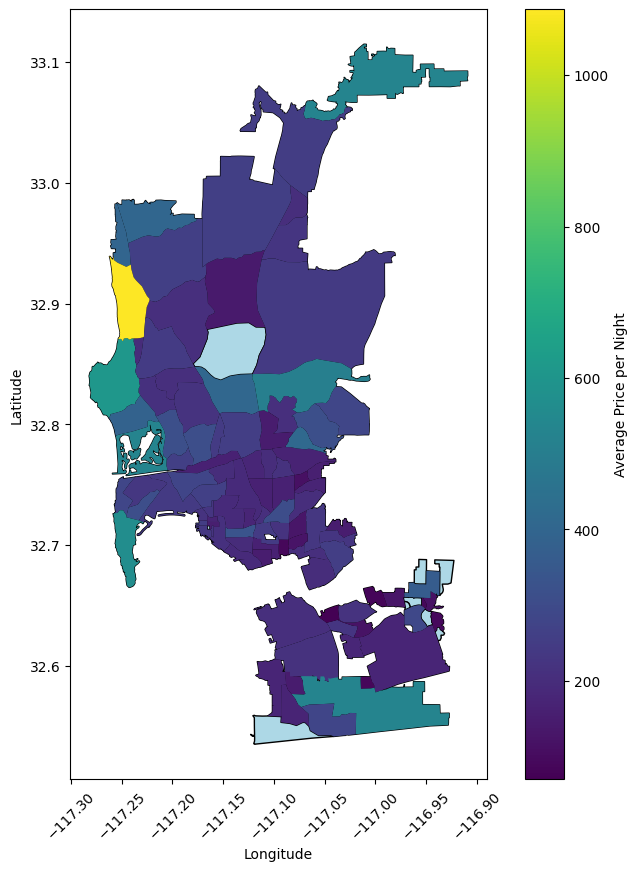

In [80]:
san_diego_data = pd.read_csv('san_diego_listing_cleaned.csv')
san_diego_shapefile = "sandiego.geojson"

shapefile_path = san_diego_shapefile
gdf = gpd.read_file(shapefile_path)
data = san_diego_data

average_price_per_neighborhood = data.groupby('neighbourhood_cleansed')['price'].mean().sort_values()
# print(average_price_per_neighborhood)
# Plot the neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot the average price per neighborhood
gdf['average_price'] = gdf['neighbourhood'].map(average_price_per_neighborhood)
gdf.plot(column='average_price', ax=ax, legend=True, legend_kwds={'label': "Average Price per Night"})

#rotate the x-axis labels
plt.xticks(rotation=45)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average Price per Night vs. Neighborhood in {}'.format(plotting))
plt.tight_layout()
plt.savefig('plots/san_diego_price_per_neighborhood.pdf')